## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________________________________


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Numbers of exp: 1, reduce_factor: 0.99, reduce_patient: 5
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)            

Epoch 13/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4928 - acc: 0.4814 - val_loss: 1.6127 - val_acc: 0.4376
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4751 - acc: 0.4875 - val_loss: 1.6032 - val_acc: 0.4390
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4602 - acc: 0.4939 - val_loss: 1.5958 - val_acc: 0.4410
Epoch 16/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4456 - acc: 0.4983 - val_loss: 1.5890 - val_acc: 0.4457
Epoch 17/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4316 - acc: 0.5038 - val_loss: 1.5803 - val_acc: 0.4458
Epoch 18/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4154 - acc: 0.5096 - val_loss: 1.5717 - val_acc: 0.4500
Epoch 19/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.4027 - acc: 0.5137 - val_loss: 1.5642 - val_acc: 0.4489
Epoch 20/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 56us/step - loss: 2.4784 - acc: 0.1976 - val_loss: 2.3311 - val_acc: 0.2550
Epoch 2/25
50000/50000 [==============================] - 2s 39us/step - loss: 2.0198 - acc: 0.3086 - val_loss: 2.0282 - val_acc: 0.3161
Epoch 3/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.8728 - acc: 0.3513 - val_loss: 1.9052 - val_acc: 0.3492
Epoch 4/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.7894 - acc: 0.3770 - val_loss: 1.8338 - val_acc: 0.3655
Epoch 5/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.7300 - acc: 0.3965 - val_loss: 1.7927 - val_acc: 0.3801
Epoch 6/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.6840 - acc: 0.4122 - val_loss: 1.7576 - val_acc: 0.3906
Epoch 7/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.6484 - acc: 0.4236 - val_loss: 1.7306 - val_acc

50000/50000 [==============================] - 2s 44us/step - loss: 1.3484 - acc: 0.5330 - val_loss: 1.5302 - val_acc: 0.4717
Epoch 25/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3358 - acc: 0.5369 - val_loss: 1.5277 - val_acc: 0.4692
Numbers of exp: 6, reduce_factor: 0.10, reduce_patient: 3
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
b

50000/50000 [==============================] - 2s 39us/step - loss: 1.5201 - acc: 0.4673 - val_loss: 1.6412 - val_acc: 0.4288
Epoch 12/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4998 - acc: 0.4757 - val_loss: 1.6271 - val_acc: 0.4360
Epoch 13/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.4797 - acc: 0.4818 - val_loss: 1.6159 - val_acc: 0.4374
Epoch 14/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4626 - acc: 0.4875 - val_loss: 1.6058 - val_acc: 0.4418
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 1.4466 - acc: 0.4931 - val_loss: 1.5944 - val_acc: 0.4440
Epoch 16/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4307 - acc: 0.5003 - val_loss: 1.5894 - val_acc: 0.4472
Epoch 17/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.4153 - acc: 0.5058 - val_loss: 1.5817 - val_acc: 0.4529
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7668 - acc: 0.3862 - val_loss: 1.8882 - val_acc: 0.3748
Epoch 2/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4943 - acc: 0.4739 - val_loss: 1.7014 - val_acc: 0.4138
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3926 - acc: 0.5096 - val_loss: 1.9947 - val_acc: 0.3315
Epoch 4/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.3166 - acc: 0.5348 - val_loss: 1.7821 - val_acc: 0.3775
Epoch 5/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.2524 - acc: 0.5601 - val_loss: 1.7993 - val_acc: 0.3739

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1474 - acc: 0.5992 - val_loss: 1.5569 - val_acc: 0.4513
Epoch 7/25
50000/50000 [=======================

50000/50000 [==============================] - 2s 41us/step - loss: 1.0118 - acc: 0.6639 - val_loss: 1.4491 - val_acc: 0.4963
Epoch 22/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.9965 - acc: 0.6694 - val_loss: 1.4321 - val_acc: 0.5041
Epoch 23/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.9812 - acc: 0.6739 - val_loss: 1.4428 - val_acc: 0.4973
Epoch 24/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.9671 - acc: 0.6796 - val_loss: 1.4408 - val_acc: 0.5037
Epoch 25/25
50000/50000 [==============================] - 2s 41us/step - loss: 0.9518 - acc: 0.6881 - val_loss: 1.4388 - val_acc: 0.5029
Numbers of exp: 11, reduce_factor: 0.99, reduce_patient: 10
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
______________________________________________

50000/50000 [==============================] - 2s 41us/step - loss: 1.2741 - acc: 0.5562 - val_loss: 1.5075 - val_acc: 0.4673
Epoch 9/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.2467 - acc: 0.5688 - val_loss: 1.4906 - val_acc: 0.4745
Epoch 10/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2213 - acc: 0.5791 - val_loss: 1.4913 - val_acc: 0.4799
Epoch 11/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1950 - acc: 0.5881 - val_loss: 1.4777 - val_acc: 0.4817
Epoch 12/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1723 - acc: 0.5964 - val_loss: 1.4772 - val_acc: 0.4788
Epoch 13/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1496 - acc: 0.6071 - val_loss: 1.4726 - val_acc: 0.4852
Epoch 14/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1302 - acc: 0.6144 - val_loss: 1.4635 - val_acc: 0.4868
Epoch 15/25
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 86us/step - loss: 2.0286 - acc: 0.3131 - val_loss: 2.1006 - val_acc: 0.3290
Epoch 2/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.6786 - acc: 0.4156 - val_loss: 1.7688 - val_acc: 0.3931
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5796 - acc: 0.4470 - val_loss: 1.6819 - val_acc: 0.4125
Epoch 4/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.5187 - acc: 0.4688 - val_loss: 1.6320 - val_acc: 0.4254
Epoch 5/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4738 - acc: 0.4852 - val_loss: 1.5975 - val_acc: 0.4404
Epoch 6/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4377 - acc: 0.4986 - val_loss: 1.5836 - val_acc: 0.4475
Epoch 7/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4076 - acc: 0.5106 - val_loss: 1.5667 - val_acc

50000/50000 [==============================] - 2s 40us/step - loss: 1.1348 - acc: 0.6162 - val_loss: 1.4604 - val_acc: 0.4918
Epoch 25/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.1278 - acc: 0.6167 - val_loss: 1.4636 - val_acc: 0.4912
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 5
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________

50000/50000 [==============================] - 2s 41us/step - loss: 1.4720 - acc: 0.4884 - val_loss: 1.6149 - val_acc: 0.4383
Epoch 12/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4578 - acc: 0.4941 - val_loss: 1.6051 - val_acc: 0.4388
Epoch 13/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4428 - acc: 0.4983 - val_loss: 1.5995 - val_acc: 0.4439
Epoch 14/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4296 - acc: 0.5055 - val_loss: 1.5963 - val_acc: 0.4412
Epoch 15/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4164 - acc: 0.5100 - val_loss: 1.5925 - val_acc: 0.4420
Epoch 16/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4049 - acc: 0.5135 - val_loss: 1.5833 - val_acc: 0.4475
Epoch 17/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3936 - acc: 0.5184 - val_loss: 1.5774 - val_acc: 0.4516
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 100us/step - loss: 2.0556 - acc: 0.3051 - val_loss: 1.9471 - val_acc: 0.3418
Epoch 2/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7036 - acc: 0.4086 - val_loss: 1.8081 - val_acc: 0.3896
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5779 - acc: 0.4496 - val_loss: 1.7047 - val_acc: 0.4205
Epoch 4/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4964 - acc: 0.4771 - val_loss: 1.6647 - val_acc: 0.4246
Epoch 5/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4318 - acc: 0.5028 - val_loss: 1.6498 - val_acc: 0.4254
Epoch 6/25
50000/50000 [==============================] - 2s 44us/step - loss: 1.3817 - acc: 0.5196 - val_loss: 1.6037 - val_acc: 0.4395
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3381 - acc: 0.5367 - val_loss: 1.6207 - val_ac

50000/50000 [==============================] - 2s 41us/step - loss: 1.1134 - acc: 0.6211 - val_loss: 1.5332 - val_acc: 0.4672
Epoch 24/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.0980 - acc: 0.6288 - val_loss: 1.4978 - val_acc: 0.4840
Epoch 25/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.0810 - acc: 0.6365 - val_loss: 1.5000 - val_acc: 0.4813
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 3
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_64 (Batc (None, 512)               2048      
___________________________________________________________

50000/50000 [==============================] - 2s 41us/step - loss: 1.3766 - acc: 0.5238 - val_loss: 1.5669 - val_acc: 0.4499
Epoch 11/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3477 - acc: 0.5344 - val_loss: 1.5529 - val_acc: 0.4553
Epoch 12/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.3218 - acc: 0.5432 - val_loss: 1.5582 - val_acc: 0.4589
Epoch 13/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2971 - acc: 0.5523 - val_loss: 1.5404 - val_acc: 0.4671
Epoch 14/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2737 - acc: 0.5619 - val_loss: 1.5351 - val_acc: 0.4662
Epoch 15/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2508 - acc: 0.5710 - val_loss: 1.5483 - val_acc: 0.4630
Epoch 16/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.2295 - acc: 0.5802 - val_loss: 1.5081 - val_acc: 0.4716
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 109us/step - loss: 2.2123 - acc: 0.2675 - val_loss: 2.0857 - val_acc: 0.3029
Epoch 2/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.8705 - acc: 0.3589 - val_loss: 2.0039 - val_acc: 0.3359
Epoch 3/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.7389 - acc: 0.3991 - val_loss: 1.8259 - val_acc: 0.3774
Epoch 4/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.6530 - acc: 0.4280 - val_loss: 1.7580 - val_acc: 0.3936
Epoch 5/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5892 - acc: 0.4512 - val_loss: 1.7018 - val_acc: 0.4099
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.5390 - acc: 0.4687 - val_loss: 1.6926 - val_acc: 0.4258
Epoch 7/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4945 - acc: 0.4846 - val_loss: 1.6518 - val_ac

50000/50000 [==============================] - 2s 40us/step - loss: 1.0828 - acc: 0.6379 - val_loss: 1.5020 - val_acc: 0.4834
Epoch 25/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.0669 - acc: 0.6447 - val_loss: 1.5098 - val_acc: 0.4801
Numbers of exp: 26, reduce_factor: 0.10, reduce_patient: 10
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_79 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________________________

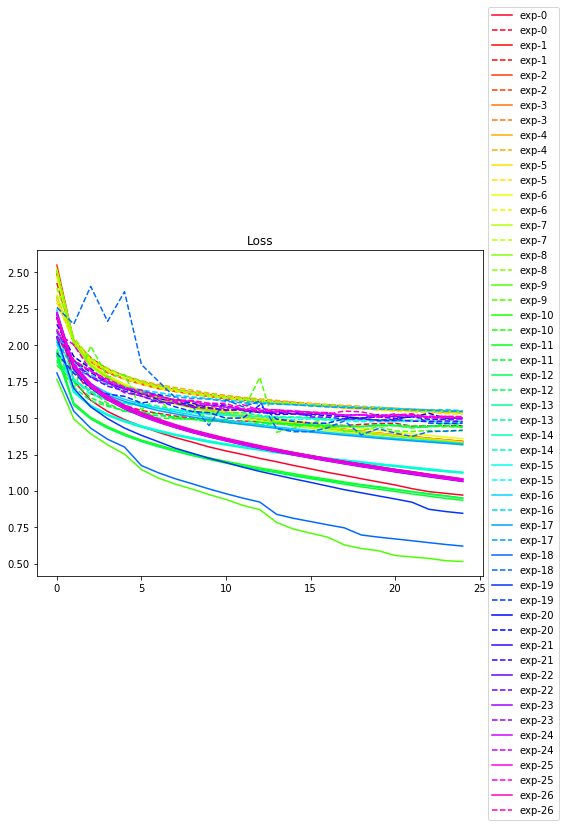

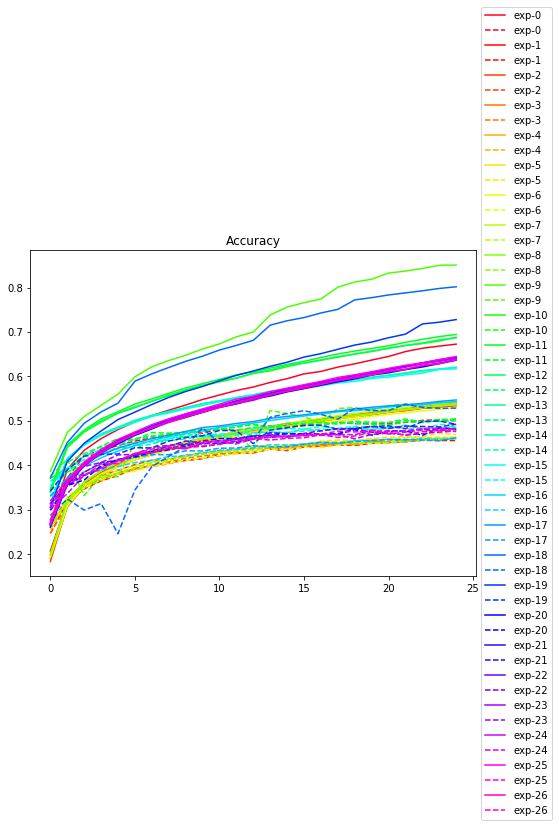

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()